In [11]:
# import libraries

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE 
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


In [12]:
# read data
iris = pd.read_csv("test-data-iris.txt", sep = ' ', header = None)
starlight = pd.read_csv("StarlightCurves.csv", header = None)

In [13]:
iris.head()

,0,1,2,3
0,5.7,4.4,1.5,0.4
1,5.5,4.2,1.4,0.2
2,5.2,4.1,1.5,0.1
3,5.8,4.0,1.2,0.2
4,5.4,3.9,1.7,0.4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


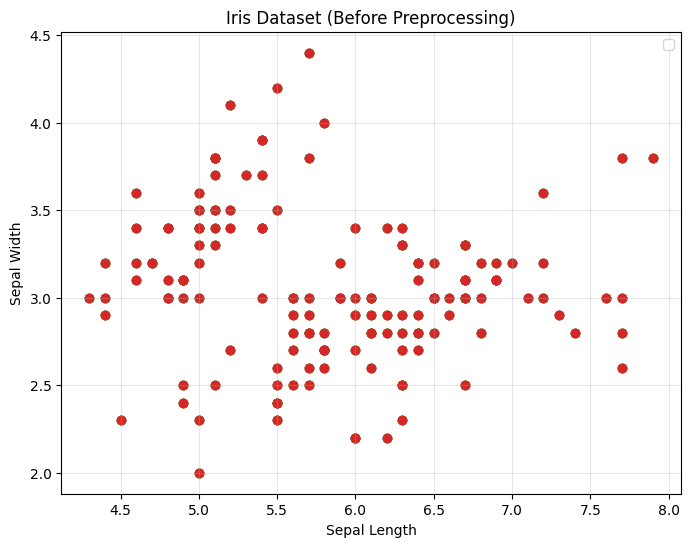

In [46]:
plt.figure(figsize=(8, 6))
for i in iris:
    plt.scatter(
        iris.iloc[:, 0],  
        iris.iloc[:, 1]
    )

# Add labels and title
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset (Before Preprocessing)')
plt.legend()
plt.grid(alpha=0.3)
#plt.show()
plt.savefig("iris_before_preprocessing")

In [108]:
# libraries only used for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Normalize and dimensionality reduction
def preProcess(data, normal=False, n_components=2):
    
    # normalize data
    scaled = None
    if normalize == True:
        scaled = normalize(data)
    else:
        # standard scaler standardizes the features by removing the mean and scaling to unit variance
        s = StandardScaler()
        scaled = pd.DataFrame(s.fit_transform(data)) # put back into df
    
    # perform dimensionality reduction on the normalized data and return the reduced data
    pca = PCA(n_components=n_components) # how many components should we keep? 
    pca.fit(scaled)

    reduced = pca.transform(scaled)
    reduced_data = pd.DataFrame(reduced) # put back into df
    
    return reduced_data

In [138]:
#data_images = preProcess(starlight)
data_iris_normal = preProcess(iris, normal=True, n_components=3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


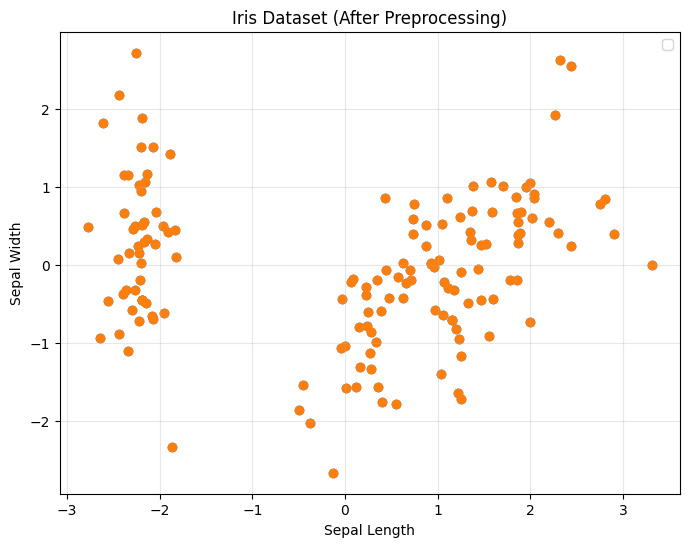

In [110]:
plt.figure(figsize=(8, 6))
for i in data_iris_normal:
    plt.scatter(
        data_iris_normal.iloc[:, 0],  
        data_iris_normal.iloc[:, 1]
    )

# Add labels and title
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset (After Preprocessing)')
plt.legend()
plt.grid(alpha=0.3)
#plt.show()
plt.savefig("iris_after_preprocessing")

In [121]:
# Implement the KMeans clustering 



class KMeans:
    '''
    K - number of clusters
    '''
    def __init__(self, k=3, return_sse = False, seed=1, plot=True):
        self.k = k
        self.return_sse = return_sse 
        self.err = 1e-08 # error
        np.random.seed(seed)
        self.plot = plot

    
    def fit_predict(self, data):
        self.data = data
        
        # Initialize the centroids 
        self.centroids = self.initialize_centroids()

        i = 0
        print("Thinking", end='')
        while True:
            i += 1
            print(".", end='')
            ''' After initializing the centroids, calculate the distance of each sample/row to the centroids
                For every row/sample you should get k distances, one for each centroid'''
            
            distances = self.distances()

            # Assign each data point to the cluster represented by the index of its nearest centroid.
            self.cluster_indices = self.cluster_assign(distances) # Determine the index of the centroid with the minimum distance.
            if i == 1 and self.plot:
                self.plot_clusters(i)
            
            
            self.old_centroids = self.centroids.copy()

            self.centroids = self.update_centroids(self.cluster_indices)

            # Plot clusters
            if self.plot:
                self.plot_clusters(i)

            
            ''' Compare whether the old centroids and newly computed centroids are equal, 
            if they are equal terminate the algorithm '''
            # compare here using self.err
            if self.compare_centroids():
                # if centroids are equal break out of the main loop
                break
        
        
        if self.return_sse:
            sse = self.compute_sse()

            return sse
        
        return self.cluster_indices


    
    def compare_centroids(self):
        old = np.array(self.old_centroids)
        new = np.array(self.centroids)

        # allclose returns true if two arrays are element-wise equal within tolerance
        for i in range(self.k):
            if not np.allclose(old, new, rtol=self.err):
                return False

        return True


    
    # Assign each point to a cluster point 
    def cluster_assign(self, distances):

        return np.argmin(distances, axis=1)

    
    # Update each centroid by computing the mean of the data points assigned to its cluster.
    def update_centroids(self, labels):
        
        updated_centroids = np.zeros(shape=(self.k, self.data.shape[1])) # ex. (3, 4)
        
        for i in range(self.k):
            # get all the data points assigned to this cluster
            cluster_points = self.data[labels == i]

            # sometimes no points will be assigned to this cluster, how to handle?
            if len(cluster_points) == 0:
                # just choose a random point for now
                updated_centroids[i] = self.data[np.random.choice(range(len(self.data)))]

            
            # calculate the mean across the x-axis
            updated_centroids[i] = cluster_points.mean(axis=0) 

        return updated_centroids
    
    
    # This method initializes the centroids
    # Initialize the centriods randomly
    def initialize_centroids(self):
        # initialize centroids using self.data and self.k
        centroids = []
        for i in range(self.k):
            # just choose a random row
            centroids.append(self.data.loc[np.random.choice(range(len(self.data)))])
            
        return centroids

    # This method calculates the distance using np arrays
    def distances(self):
        # calculate distance using self.data and self.centroids
        d = np.array(self.data)
        c = np.array(self.centroids)


        # we can use numpy quick broadcasting techniques but we have to add a new dimension
        data = d[:, np.newaxis, :]

        centroids = c[np.newaxis, :, :]
    
        euclid = ((data - centroids) ** 2).sum(axis=2)
        
        return np.sqrt(euclid)
     
        
    
    # Compute SSE (Sum of Squared Errors) (Use can implement any objective function of your choice)
    def compute_sse(self):
        # compute sse using self.data, self.cluster_indices, self.k (refer to the formula mentioned in KMeans slides)
        sse = 0.0
        for i in range(len(self.data)):  # Loop over each cluster
            # Get points assigned to the current cluster
            cluster = self.cluster_indices[i]

            centroid = self.centroids[cluster]
            
            squared = np.sum((self.data.iloc[i] - centroid) ** 2 )

            sse += squared
        
        return sse


    def plot_clusters(self, iteration):
        colors = ['red', 'blue', 'green', 'purple', 'orange']
        plt.figure(figsize=(8, 6))
        for i in range(self.k):
            cluster_points = self.data[self.cluster_indices == i]
            plt.scatter(cluster_points[cluster_points.columns[0]], cluster_points[cluster_points.columns[1]], s=25, color=colors[i % len(colors)], label=f"Cluster {i+1}")
        
        # Plot centroids
        centroids = np.array(self.centroids)
        plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='yellow', label='Centroids')

        plt.title(f"Starlight Curves K-Means Clustering :K={self.k}: Iteration {iteration}")
        plt.legend()
        plt.show()
        #plt.savefig("iter"+str(i)+".png")


Thinking.

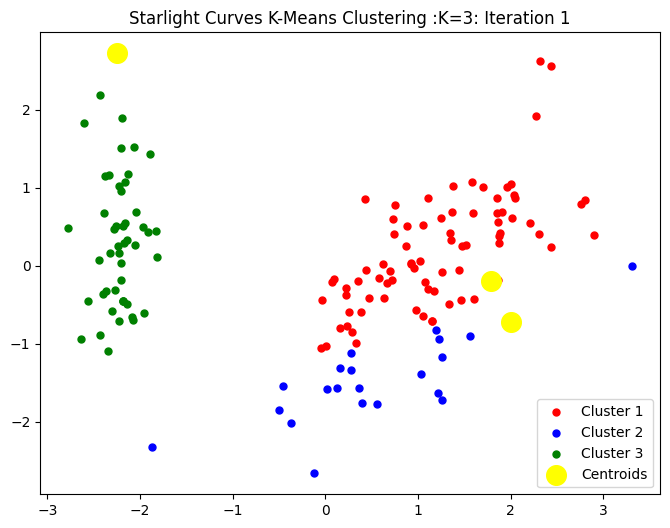

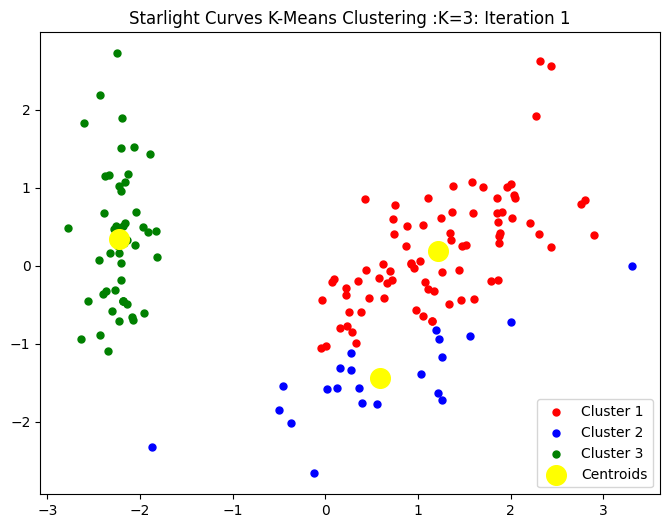

.

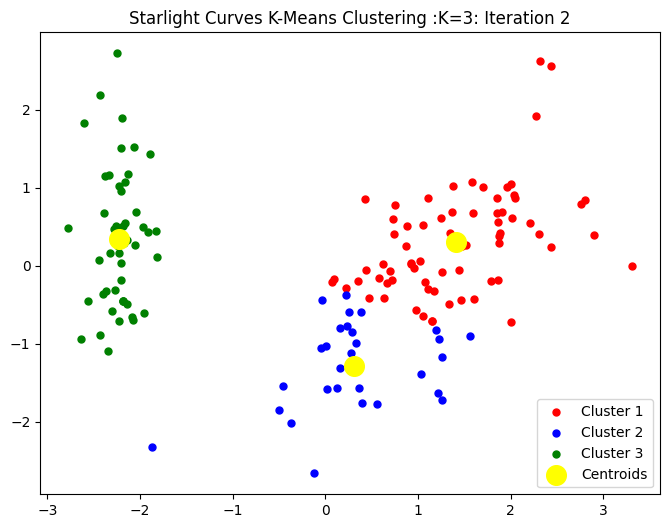

.

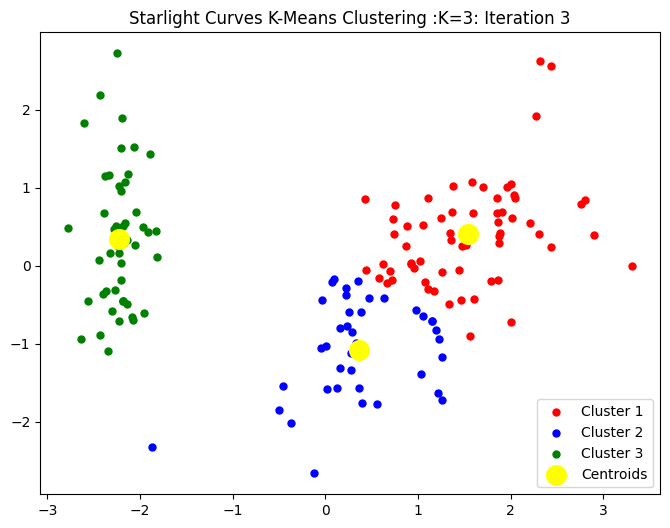

.

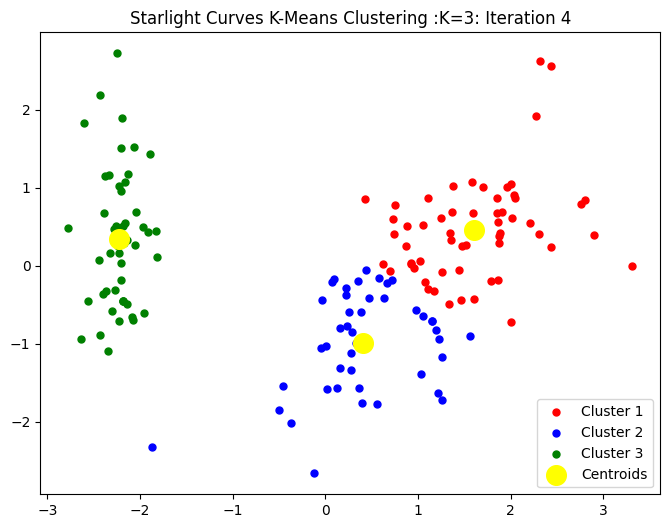

.

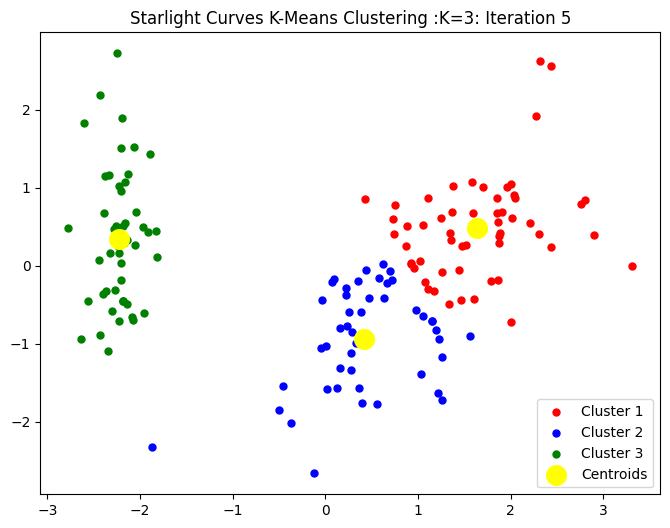

.

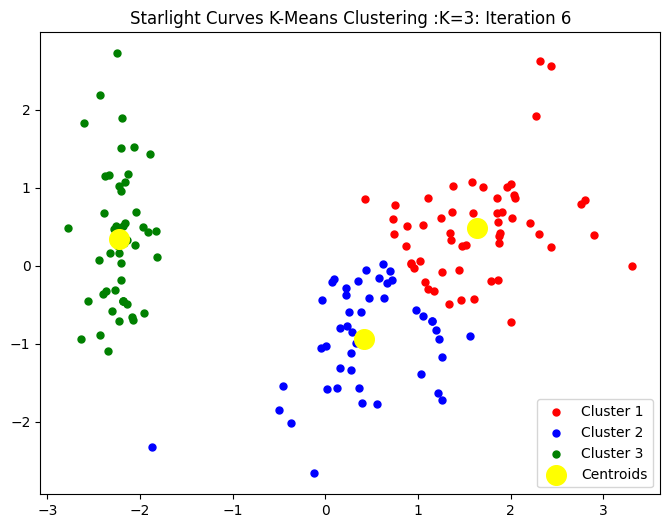


[2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2 0
 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 1 2 2 2 2 2 2 0 0 1 0 1 1 1 1 1 2 0 0 0 0 0 0 1 0
 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


In [139]:
km = KMeans(k=3, return_sse = False, seed = 3, plot=True)

indicies = km.fit_predict(data_iris)
print()
print(indicies)

with open("output.txt", 'w') as f:
    for val in indicies:
        f.write(str(val+1) + "\n")


In [99]:
def plot_sse(sse, K):
    # plot of objective function (y-axis) vs. value of K increasing from 2 to 20 in steps of 2 (x-axis)
    plt.figure(figsize=(8,6))
    plt.plot(K, sse, label='deviation')
    plt.xlabel("K - Clusters")
    plt.ylabel("SSE")
    plt.legend()
    plt.show()
    

    

# Objective function vs K for Iris

Thinking..Thinking.....Thinking......Thinking.......Thinking..........Thinking........Thinking..........Thinking............Thinking............Thinking..........

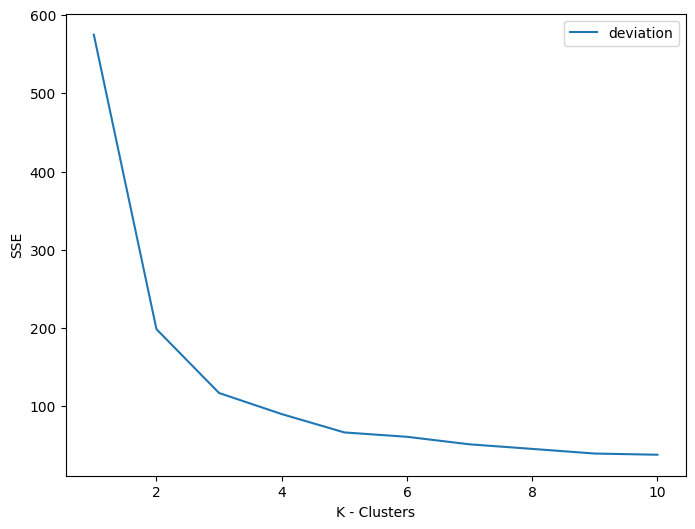

In [107]:
K = [i for i in range(1,11)]
sse = []
for k in K:
    model = KMeans(k = k, return_sse = True, plot=False, seed=3)
    sse.append(model.fit_predict(data_iris))


plot_sse(sse, K)

# Make cluster assignments for Iris data

In [ ]:
# Initialize KMeans class with k = 3 and get the clusters
# Write the clusters to .txt file and upload the file to miner

# Objective function vs K for Startlight data

# Make cluster assignments for Starlight data

In [111]:
starlight.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.569701,-0.567901,-0.565901,-0.563701,-0.561501,-0.559101,-0.556701,-0.554101,-0.551501,-0.548701,...,-0.518401,-0.521501,-0.525101,-0.529001,-0.533201,-0.537901,-0.543001,-0.548501,-0.554501,-0.560801
1,-0.528303,-0.520903,-0.512903,-0.504303,-0.494903,-0.485003,-0.474403,-0.463203,-0.451303,-0.438903,...,-0.673504,-0.670104,-0.664604,-0.656704,-0.646504,-0.633804,-0.618604,-0.600603,-0.579903,-0.556303
2,0.164201,0.181901,0.198601,0.214301,0.229001,0.242701,0.255501,0.267401,0.278401,0.288601,...,0.233501,0.225401,0.217301,0.209201,0.201101,0.193101,0.185201,0.177301,0.169401,0.161701
3,0.321800,0.327001,0.332401,0.337901,0.343501,0.349201,0.355001,0.360801,0.366701,0.372701,...,0.262200,0.268300,0.274400,0.280500,0.286600,0.292600,0.298600,0.304600,0.310500,0.316400
4,-0.461699,-0.464499,-0.466499,-0.467499,-0.467699,-0.467099,-0.465699,-0.463499,-0.460599,-0.457099,...,-0.465999,-0.465899,-0.466399,-0.467399,-0.468999,-0.471099,-0.473799,-0.477099,-0.480999,-0.485499


In [132]:
data_starlight = preProcess(starlight, n_components=10)

In [128]:
data_starlight.head()

,0,1,2,3,4,5,6,7,8,9
0,-33.241309,-4.939142,2.779934,-11.218485,2.750060,-4.139872,-0.265967,-11.824072,2.066521,0.991348
1,4.977932,22.206974,12.319796,-0.508427,-4.032980,-0.715537,1.225330,3.618938,5.151570,-3.274531
2,10.517719,12.596730,9.728854,2.381770,3.715115,1.721827,-1.977654,-2.711368,-1.737589,2.180169
3,12.678429,20.758469,7.614729,-1.718404,-1.865326,2.452246,1.371630,1.195869,1.044701,-0.752863
4,-30.917517,-3.135375,1.662428,7.750174,0.533028,10.242988,2.398214,-4.493038,1.387995,-1.904723


In [129]:
# Initialize KMeans class with k = 3 and get the clusters
# Write the clusters to .txt file and upload the file to miner

km = KMeans(k=3, return_sse = False, seed=1, plot=False)

indicies = km.fit_predict(data_starlight)
print()
print(indicies)


Thinking...............
[1 2 2 ... 0 1 2]


Thinking.........Thinking.................................Thinking.........................Thinking................................................................Thinking.........................Thinking........................................Thinking.................................Thinking...................................................................Thinking........................................................................................................................................................Thinking..............................................................................................

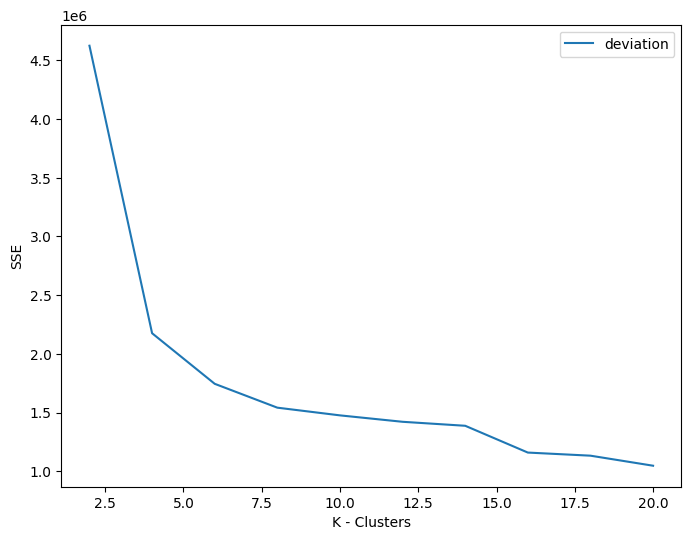

In [135]:
# if plot is set to true this will take a while to run...

K = [i for i in range(2,21, 2)]
sse = []
for k in K:
    model = KMeans(k = k, return_sse = True, plot=False)
    sse.append(model.fit_predict(data_starlight))

plot_sse(sse, K)

In [130]:
with open("outputStarlight.txt", 'w') as f:
    for val in indicies:
        f.write(str(val+1) + "\n")